In [ ]:
!pip install scikit-learn --upgrade



In [ ]:
!pip install imbalanced-learn --upgrade


In [ ]:
!pip install tensorflow-addons


Programme original : [Kaggle - Lung Cancer Prediction on Image Data](https://www.kaggle.com/code/adityamahimkar/lung-cancer-prediction-on-image-data/notebook)

# Import Packages

In [ ]:
%config Completer.use_jedi = False

import os
import random
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.image as mpimg

from PIL import Image
import imageio
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Activation, Flatten
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

La variable **categories** est une liste qui représente les différentes classes d'images présentes dans le dataset.


1.   Benign cases : Cas où les tumeurs, si elles existent, sont bénignes et non cancéreuses.
2.   Malignant cases : Cas de tumeurs malignes qui sont cancéreuses.
3. Normal cases : Représente des radiographies pulmonaires qui ne montrent aucune anomalie ou tumeur.




In [ ]:
directory = r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'

categories = ['Benign cases', 'Malignant cases', 'Normal cases']

# Image Size Variations

Avant de pouvoir analyser et classifier les images, il est nécessaire de connaître leurs dimensions au préalable.

Dans le code ci-dessous, on liste, pour chaque catégorie, les dimensions associées au nombre d'occurrence.

La fonction ```imageio.imread``` permet de lire l'image.

La propriété ```shape``` sert à obtenir les dimensions (hauteur, largeur, canaux - *nombre de couches utilisées pour coder un pixel de l'image*)

In [ ]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

<ipython-input-7-b77470758d58>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Benign cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Afin d'avoir une référence pour chaque cas et visualiser les différentes caractéristiques, on affiche une image de chaque catégorie.

Pour cela, on utilise la librairie **opencv-python (cv2)** dédiée au traitement d'images.

La fonction ```imread``` permet de lire l'image donnée en paramètre.

Le deuxième argument a pour but de définir la manière de lire l'image :

- 1 (par défaut) : image en couleur sans transparence
- 0 : image en niveau de gris
- -1 : image en couleur avec transparence

L'image rendue étant en niveau de gris, les données sont stockées dans une matrice 2D. Or, selon la [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) la fonction ```imshow``` de matplotlib, lorsqu'elle reçoit des données 2D, affiche une image en fausses couleurs.

C'est pourquoi les images que nous observerons tendront vers le vert.

Benign cases


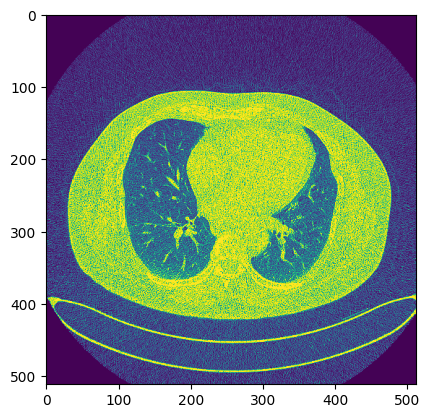

Malignant cases


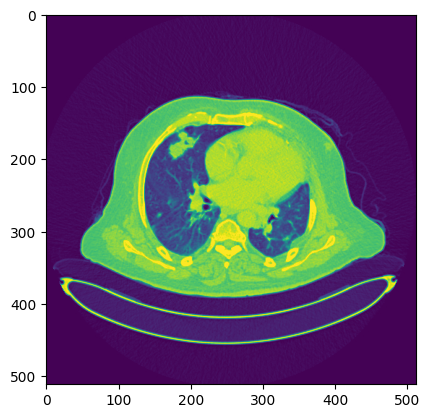

Normal cases


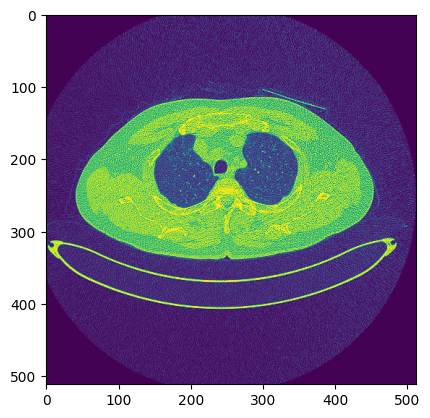

In [ ]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

# Image Preprocessing and Testing

 Pour chaque catégorie, il y aura 3 images affichées (les originales et leurs variantes) sur 3 colonnes. C'est la condition suivante qui permet d'interrompre l'affichage si le nombre d'images traitées atteint la limite défini par la variable **samples** (3 dans ce cas).
```python
if cnt == samples:
    break
```

 La taille de la figure est définie à 15x15 et le titre de la figure est défini comme la catégorie en cours d'analyse.

 Pour chaque fichier d'image :
- L'image est lue en niveau de gris
```python
img = cv2.imread(filepath, 0)
```
- L'image est redimensionnée à la taille de 256x256 pixels
- Un flou gaussien est appliqué à l'image redimensionnée pour améliorer la lisibilité de l'image en reduisant le bruit.
```python
img1 = cv2.GaussianBlur(img0, (5, 5), 0)
```





In [ ]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Preparing Data

Le tableau **data** est initialisé pour contenir les différentes images et leurs lables.
Un numéro de classe est attribué à chaque catégorie d'images (benign, malignant et normal). Les images sont encore une fois lues en niveaux de gris afin de simplifier l'analyse (moins d'information par rapport à une image en couleur). En effet, dans le cas de la détection du cancer, la couleur peut ne pas apporter d'informations supplémentaires significatives.


Les données sont ensuite mélangées à l'aide de la méthode **data.shuffle** pour assurer une distribution aléatoire des données lors de l'entrainement. Cela est nécessaire parce que si toutes les images d'une certaine catégorie sont regroupées, le modèle d'apprentissage pourrait mal performer lors des premieres étapes d'entrainement. Le modèle pourrait être temporairement biaisé vers cette catégorie jusqu'à ce qu'il voit d'autres catégories. Ce problème peut alors conduire le modèle vers un minimum local ou ralentir sa convergence durant l'entrainement.


Les images et les labels sont ensuite séparés en deux listes distinctes X et Y afin de distinguer les entrées (images) et les sorties (labels). Nous avons affaire ici à une méthode d'apprentissage supervisé, ainsi :     


*   X (caractéristiques) : Ce sont les entrées utilisées par le modèle pour faire ses prédictions. Ici, il s'agit des images.
*   Y (labels) : Ce sont les valeurs que le modèle tente de prédire. Ici il s'agit des catégories d'images (benign, malignant ou normal)


Enfin, les images sont converties en tableaux numpy et normalisées. Les valeurs des pixels d'une image varient normalement de 0 à 255. En les normalisant entre 0 et 1, les calculs se retrouvent facilités pour la phase d'entrainement du modèle.



In [ ]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


Les données sont divisées en ensembles d'entrainement et de validation en utilisant la méthode ```train_test_split()``` : elle décompose de manière aléatoire un ensemble de données. Une partie servira à l'entrainement du modèle et l'autre permettra de le tester pour la validation. L'utilisation de ```stratify=y``` s'assure que la distribution des labels dans les ensembles d'entraînement et de validation est similaire à celle de l'ensemble de données original. C'est essentiel pour garantir que l'ensemble de validation est représentatif de l'ensemble de données global.

La division des données en ensembles d'entrainement et de validation est nécessaire car si un modèle est uniquement formé et évalué sur le même ensemble de données, il peut mémoriser ces données (surapprentissage) et mal performer sur de nouvelles données. En ayant un ensemble de validation distinct, on peut obtenir une estimation plus réaliste de la performance du modèle sur des données nouvelles.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


# Applying SMOTE to oversample the data

Comme nous pouvons le constater dans la cellule ci-dessous, les données dont nous disposons ne sont pas réparties de manière équilibrée, que cela soit pour l'ensemble d'entraînement ou bien de validaton.

Par exemple, pour l'ensemble d'entraînement, on compte 420 images de cancer de type bénin *(1)*, 312 de type malin *(2)* et 90 considérés comme normaux *(0)*.

Ce déséquilibre influence fortement les performances du modèle. En effet, le nombre d'images données est un facteur important car cela permet au modèle d'acquérir plus d'expériences et d'être plus familier avec la catégorie concernée. Ainsi, plus une catégorie contient d'images, mieux le modèle saura la reconnaître à l'avenir.


Afin de pallier ce problème, on utilise la technique *Synthetic Minority Oversampling Technique* ou **SMOTE** pour créer, à partir des données existantes, de nouvelles images pour les catégories minoritaires et ainsi rééquilibrer la balance.

In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


Afin de faciliter la création de nouvelles images par la méthode SMOTE, il est nécessaire de modifier la structure des images qui sont pour le moment codées dans des matrices 2D (dont les dimensions sont 256 x 256) pour obtenir au final un tableau à 1 dimension.

Pour cela, nous utilisons la méthode ``reshape`` de numpy.

In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


  Nous allons utiliser la classe ``SMOTE`` fournie par la librairie ``imbalanced-learn (imblearn)`` pour créer les données manquantes.

  La méthode ``fit_resample`` prend en entrée 2 tableaux :
  1. les données
  2. les labels correspondants

Elle retourne les 2 tableaux transformés.

On peut désormais observer que la matrice est équilibrée. Pour les catégories minoritaires, des images ont été artificellement créées à partir des images existantes pour combler la différence.

Ainsi, pour chaque catégorie, on compte **420** images.


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# Model Building with SMOTE data

Dans la portion de code présentée ci-dessous, nous sommes confrontés à la tâche de construire un modèle d'apprentissage profond pour traiter certaines données. À première vue, on peut immédiatement identifier l'utilisation d'une architecture de réseau neuronal convolutif (CNN), couramment utilisée pour traiter des données visuelles telles que des images.

La structure de ce modèle CNN se présente comme suit:

1. Couche de convolution: Elle commence avec une couche convolutive ayant 64 filtres de taille 3x3. Cette couche est responsable de l'extraction des caractéristiques initiales des images.
Couche d'activation ReLU: Elle permet d'ajouter de la non-linéarité au modèle, en transformant les valeurs négatives en zéro et en laissant les valeurs positives inchangées.
2. MaxPooling: Elle réduit la dimensionnalité des cartes de caractéristiques en prenant la valeur maximale sur des fenêtres de taille 2x2.
Une autre suite de couche de convolution, d'activation et MaxPooling, permettant d'extraire des caractéristiques de plus haut niveau des images.
3. Flatten: Cette couche transforme la carte de caractéristiques 2D en un vecteur 1D pour le traitement ultérieur.
4. Dense: C'est une couche entièrement connectée avec 16 unités, suivie d'une autre couche Dense avec 3 unités et une activation softmax. Cette dernière couche classifie les images dans l'une des trois catégories possibles.

Après avoir défini l'architecture, le modèle est compilé avec la fonction de perte 'sparse_categorical_crossentropy', un optimiseur 'adam' et la métrique de 'précision'. Cette fonction de perte est appropriée lorsque nous avons des étiquettes de classe qui sont des entiers.

Enfin, le modèle est entraîné sur l'ensemble d'entraînement équilibré, en utilisant un batch de taille 8 et pour 10 époques. Les données de validation sont également fournies pour évaluer la performance du modèle à chaque époque.

La progression de l'entraînement montre la diminution de la perte et l'augmentation de la précision, ce qui indique que le modèle apprend bien à partir des données équilibrées grâce à SMOTE.

In [ ]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0

sparse_categorical_crossentropy : C'est une fonction de perte pour les problèmes de classification multiclasse. Elle mesure la dissimilarité entre les prédictions et la vérité.
adam : L'optimiseur Adam est une méthode de descente de gradient stochastique adaptative. Il ajuste le taux d'apprentissage pendant l'entraînement pour converger plus rapidement.

In [ ]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

L'entraînement du modèle de réseau neuronal se fait sur plusieurs cycles, qu'on appelle ici époques(epoch). À la fin de chaque époque, la performance du modèle est évaluée à la fois sur les données d'entraînement et sur les données de validation.

Perte (Loss) :
La perte est une mesure de la différence entre les prédictions du modèle et les véritables étiquettes. Plus cette valeur est faible, mieux c'est.
Sur les données d'entraînement, la perte débute à 0.5079 lors de la première époque et diminue constamment pour atteindre 0.0010 à la dixième époque. Cela signifie que le modèle s'améliore et fait de meilleures prédictions au fur et à mesure des époques.

Précision (Accuracy) :
La précision indique la proportion d'images que le modèle a correctement classées.
Sur l'ensemble d'entraînement, la précision commence à 83,89% et atteint 100% à la dixième époque. Cela montre que le modèle est devenu parfait (du moins sur l'ensemble d'entraînement) à la fin de l'entraînement.

(Val_loss) :
Il s'agit de la perte mesurée sur un ensemble de données que le modèle n'a jamais vu auparavant (données de validation). C'est une indication importante de la capacité du modèle à généraliser.
La perte sur la validation commence à 0.0934 et fluctue au cours des époques. Cela peut être dû à la complexité du modèle ou à la variabilité des données.

Précision sur la Validation (Val_accuracy) :
C'est la précision mesurée sur l'ensemble de validation.
Elle commence à 97,45% et atteint 99,64% à la dixième époque. Cela veut dire que le modèle est très performant, même sur des données qu'il n'a jamais vues.

En somme, le modèle s'est amélioré au fil des epoch, atteignant une excellente précision à la fois sur les ensembles d'entraînement et de validation. Cependant, les fluctuations de la perte de validation suggèrent qu'il pourrait être bénéfique de surveiller le modèle pour éviter un surajustement (où le modèle est trop spécifique aux données d'entraînement et moins performant sur de nouvelles données).

In [ ]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
158/158 [==============================] - 239s 2s/step - loss: 0.6068 - accuracy: 0.8048 - val_loss: 0.1095 - val_accuracy: 0.9709
Epoch 2/10
158/158 [==============================] - 241s 2s/step - loss: 0.0496 - accuracy: 0.9881 - val_loss: 0.0504 - val_accuracy: 0.9855
Epoch 3/10
158/158 [==============================] - 243s 2s/step - loss: 0.0445 - accuracy: 0.9929 - val_loss: 0.0668 - val_accuracy: 0.9745
Epoch 4/10
158/158 [==============================] - 241s 2s/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.0623 - val_accuracy: 0.9855
Epoch 5/10
158/158 [==============================] - 246s 2s/step - loss: 0.0150 - accuracy: 0.9976 - val_loss: 0.0590 - val_accuracy: 0.9927
Epoch 6/10
158/158 [==============================] - 246s 2s/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 0.0581 - val_accuracy: 0.9818
Epoch 7/10
158/158 [==============================] - 247s 2s/step - loss: 0.0245 - accuracy: 0.9968 - val_loss: 0.0577 - val_accuracy: 0.9818

# Results

Après l'entrainement du modèle avec la méthode SMOTE dans l'étape précédente, il est important d'évaluer ses performances sur un ensemble de données de validation pour s'assurer qu'il généralise bien sur les données inconnues.

Pour mesurer la qualité des prédictions, on effectue un rapport de classification : combien de prédiction sont vraies et combien sont fausses. Plus précisemment, les *vrais positifs*, les *faux positifs*, les *vrais négatifs* et les *faux négatifs* sont utilisés pour prédire les mesures d'un rapport de classification.
Le rapport montre la précision des principales mesures de classification (precision), le rappel (recall) et le score F1 par classe (F1-score).


1.   La precision permet de connaitre le nombre de prédictions positifs bien effectuées. C'est le nombre de positifs bien prédit (vrai positif) divisé par l'ensemble des positifs prédit (vrai positif + faux positif)
> $precision = \frac{Vrai Positif}{Vrai Positif + Faux Positif}$


2.   Le recall est assez similaire a la precision : il permet de connaitre le pourcentage de positifs bien prédit par le modèle. C'est le nombre de positifs bien prédit (vrai positif) divisé par l'ensemble des positifs (vrai positif + faux négatif)
> $recall = \frac{Vrai Positif}{Vrai Positif + Faux Négatif}$

  Ainsi, quand le recall est haut, cela veut dire que le modèle ne ratera aucun positif. Cependant cela ne donne aucune information sur la qualité de prédiction des négatifs.

3. Le F1-score est utilisé pour comparer les modèles de classification en déterminant lequel a le meilleur équilibre entre precision et recall. Ce n'est donc pas une mesure de la précision globale du modèle. Plus précisemment, le f1-score est ce qu'on appelle la **moyenne harmonique** qui tient compte à la fois du precision et du recall, qui séparrement sont deux métriques inutiles :
  - si le modèle prédit uniquement "positif", le recall sera élevé
  - à l'inverse, si le modèle ne prédit jamais "positif", la precision sera élevée.

  Le F1-score permet donc d'obtenir une évaluation de la performance du modèle car elle combine la precision et le recall.
> $F1{-}score = 2\times\frac{recall\times precision}{recall + precision}$

*******************************************************************************
<u> Rapport de classification </u>
*   Classe 0:
  *   Une precision de 0,93 pour la classe 0 signifie que chaque fois que le modèle prédit la classe 0, il est correcte à 93%
  *   Un recall de 0,93 signifie que le modèle a identifié 93% des instances réelles de la classe 0 dans l'ensemble de validation.
  *   Un F1-score de 0,93 est très élevé, ce qui indique un excellent équilibre entre la précision et le rappel pour cette classe.
*   Pour les Classe 1 et Classe 2, le score-F1 est très élevé (respectivement 1.0 et 0.99), indiquant une très bonne performance du modèle.

<u> Matrice de confusion </u>

La matrice de confusion donne une représentation tabulaire des prédictions du modèle par rapport aux véritables labels. Pour cet ensemble de validation on a :

*   Classe 0 :     
  - Vrais positifs (VP) : 28 instances ont été correctement identifiées comme appartenant à la classe 0
  - Faux positifs (FP) : 0 (aucune instance d'une autre classe n'a été incorrectement classifiée comme appartenant à la classe 0)
  - Faux négatifs (FN) : 2 instances ont été incorrectement classées comme n'appartenant pas à la classe 0 alors qu'elle en fait partie. La valeur "2" se trouve à la position (0,2), donc cette instance a été prédite comme appartenant à la Classe 2.
*   Classe 1 :    
  - Vrais positifs (VP) : 140 instances ont été correctement identifiées comme appartenant à la classe 1
  - Faux positifs (FP) : 0
  - Faux négatifs (FN) : 1 instance de la classe 1 a été incorrectement identifiées.
*   Classe 2 :    
  - Vrais positifs (VP) : 103 instances ont été correctement identifiées comme appartenant à la classe 2
  - Faux positifs (FP) : 2 instances de la Classe 0 ont été prédites comme appartenant à la Classe 2
  - Faux négatifs (FN) : 1 instance de la classe 2 a été incorrectement classée.


Le modèle montre une assez performance de classification pour ces trois classes. En effet il y a 2 instances de la classe 0 qui ont été incorrectement classée comme appartenant à la classe 2, 1 instance de la classe 1 et 1 instance de la classe 2 qui ont été prédite comme appartenant à la classe 0.

In [ ]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 14s 2s/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       1.00      0.99      1.00       141
           2       0.98      0.99      0.99       104

    accuracy                           0.99       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.99      0.99      0.99       275

[[ 28   0   2]
 [  1 140   0]
 [  1   0 103]]


Les graphiques suivants montrent comment le modèle a évolué au fil des époques pendant l'entraînement. Ces graphiques sont essentiels pour identifier les éventuels signes de surapprentissage ou de convergence.

1.   Précision du modèle:

On observe une amélioration rapide de la précision du modèle sur l'ensemble d'entraînement lors des premières époques. Cela indique que le modèle apprend effectivement des données d'entraînement.
La précision sur l'ensemble de validation est légèrement inférieure à celle de l'entraînement, mais elle reste relativement stable. Cela suggère que le modèle ne surapprend pas et généralise bien sur les nouvelles données.

2.   Perte du modèle:

La perte décrit l'erreur du modèle. Une valeur de perte faible indique donc de bonnes performances.<br>
La perte diminue rapidement lors des premières époques pour l'ensemble d'entraînement. Cependant, elle se stabilise par la suite.
La perte sur l'ensemble de validation est un indicateur de la capacité du modèle à généraliser. Dans notre cas elle semble stable. Il est à noter qu'une perte croissante pourrait indiquer un surapprentissage.

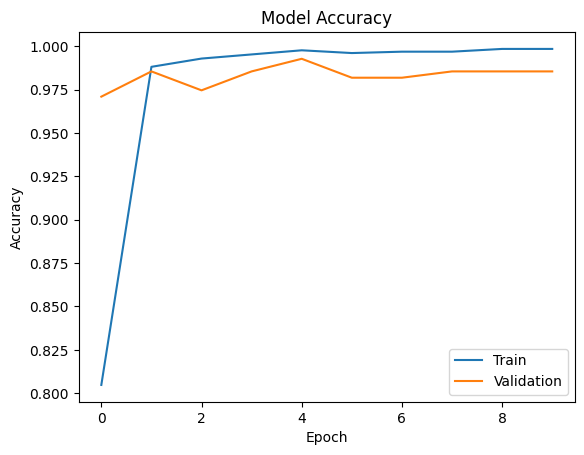

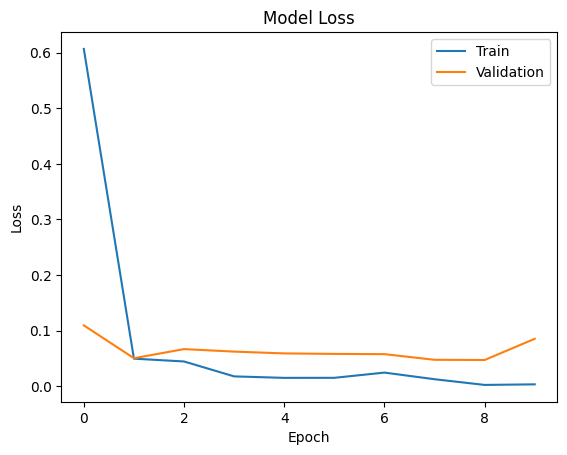

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model Building with Class Weighted Approach

Class Weighted Approach est une technique utilisée pour gérer le déséquilibre des classes dans les ensembles de données de classification. L'idée de base est de donner plus d'importance (ou de poids) aux classes moins fréquentes lors de l'entraînement du modèle.
Ici, il met en place une architecture de réseau neuronal pour la classification d'images, en tenant compte du déséquilibre potentiel des classes. Plutôt que d'utiliser la technique SMOTE pour sur-échantillonner les données, cette approche utilise des poids pour compenser le déséquilibre lors de l'entraînement. Cela garantit que le modèle est sensible aux classes moins fréquentes, sans avoir besoin de créer artificiellement de nouvelles données.

L'avantage de cette méthode est que contrairement à d'autres techniques comme le sur-échantillonnage ou le sous-échantillonnage, l'approche pondérée par classe ne modifie pas l'ensemble de données original. Elle n'ajoute ni ne supprime d'échantillons.
Elle est souvent plus simple à mettre en œuvre, car elle ne nécessite qu'un ajustement des poids de la fonction de coût.



Ci-dessous on a donc : le réseau neuronal convolutif pour traiter des images, comprenant 2 couches de convolution, des fonctions d'activation ReLU, des couches de pooling pour réduire la dimensionnalité, et des couches denses pour la classification finale. Le modèle se termine par trois neurones, suggérant une classification en trois catégories, et utilise au total 397,8391 paramètres.

In [ ]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_1 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 246016)           

Ici, le modele est compilé en utilisant la fonction de perte 'sparse_categorical_crossentropy' et l'optimiseur 'adam' avec une métrique de précision. Cependant, un aspect crucial abordé est le déséquilibre des données.

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Pour rectifier ce déséquilibre, des poids pour chaque classe, nommés 'new_weights', sont calculés. Ces poids sont définis en fonction de la distribution des classes dans l'ensemble d'entraînement. Par conséquent, le modèle est ensuite formé en tenant compte de ces poids, ce qui garantit qu'il ne néglige pas les classes moins représentées pendant l'entraînement.

In [ ]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

On observe donc que modèle a été entraîné sur 10 époques. Au fil de l'entraînement, la précision sur les données d'entraînement s'est améliorée, atteignant presque 99%, tandis que l'erreur a diminué. Sur l'ensemble de validation, la précision est également élevée, suggérant que le modèle généralise bien sur de nouvelles données. En bref, l'entraînement a été positif et le modèle présente de bonnes performances.

In [ ]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/10
103/103 [==============================] - 175s 2s/step - loss: 0.6803 - accuracy: 0.7762 - val_loss: 0.1579 - val_accuracy: 0.9382
Epoch 2/10
103/103 [==============================] - 156s 2s/step - loss: 0.0975 - accuracy: 0.9769 - val_loss: 0.0566 - val_accuracy: 0.9891
Epoch 3/10
103/103 [==============================] - 157s 2s/step - loss: 0.0493 - accuracy: 0.9951 - val_loss: 0.0399 - val_accuracy: 0.9818
Epoch 4/10
103/103 [==============================] - 155s 2s/step - loss: 0.0424 - accuracy: 0.9903 - val_loss: 0.1190 - val_accuracy: 0.9636
Epoch 5/10
103/103 [==============================] - 163s 2s/step - loss: 0.1209 - accuracy: 0.9672 - val_loss: 0.0817 - val_accuracy: 0.9709
Epoch 6/10
103/103 [==============================] - 158s 2s/step - loss: 0.0284 - accuracy: 0.9939 - val_loss: 0.0553 - val_accuracy: 0.9818
Epoch 7/10
103/103 [==============================] - 166s 2s/step - loss: 0.0532 - accuracy: 0.9927 - val_loss: 0.0254 - val_accuracy: 0.9891

# Results

L'entrainement précédent utilise une approche de pondération des classes. Nous évaluons ensuite les performances du modèle.


Le rapport de classification montre :    
*   Pour la classe 0 : la précision et le rappel sont de 0,97, ce qui signifie que lorsque le modèle prédit la classe 0, il est correct 97% du temps et le modèle identifie correctement 97% des véritables instances de la classe 0. La combinaison de ces deux scores donne un F1-score de 0,97.
*   Pour la classe 1 :  les scores sont élevés avec une précision, un rappel, et un F1-score à 0.99, 1.00 et 0.99 respectivement.
*   Pour la classe 2 :  la précision est à 0.99, tandis que le rappel est de 0.97, résultant en un f1-score de 0.98 .


La matrice de confusion montre :
*    Les valeurs diagonales représentent les bonnes classifications pour chaque classe. On observe que la majorité des prédictions sont correctes. Cependant, il y a des erreurs, notamment 1 instance de la classe 0 et 3 (1+2) instances de la classe 2 qui ont été mal classées.







In [ ]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 13s 1s/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.99      1.00      0.99       141
           2       0.99      0.97      0.98       104

    accuracy                           0.99       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 29   0   1]
 [  0 141   0]
 [  1   2 101]]


Ensuite, en analysant les graphiques :    


1.   Précision du modèle

Après le premier epoch, la précision sur l'ensemble d'entraînement augmente considérablement pour se stabiliser autour de 1.0. Cependant, la précision de validation fluctue au cours des epochs et montre une légère baisse à la fin. Cela pourrait indiquer un début de surapprentissage (overfitting).

2.   Perte du modèle

La perte d'entraînement diminue rapidement au début, puis semble fluctuer légèrement tout en se stabilisant vers une valeur basse. La perte de validation, quant à elle, fluctue tout au long des epochs et montre une augmentation vers la fin. Ceci, couplé au graphique de précision, renforce l'idée que le modèle commence à sur-entraîner après quelques epochs.



Le modèle semble assez performant, mais il pourrait bénéficier d'un ajustement de certains paramètres pour l'améliorer. Pour éviter le surapprentissage (overfitting), on pourrait par exemple envisager d'arrêter l'entrainement plus tòt.

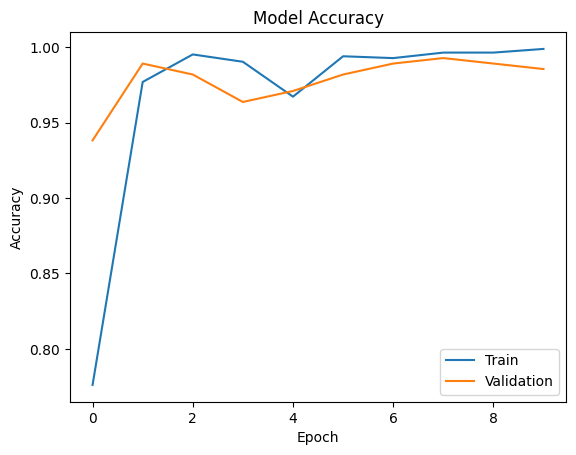

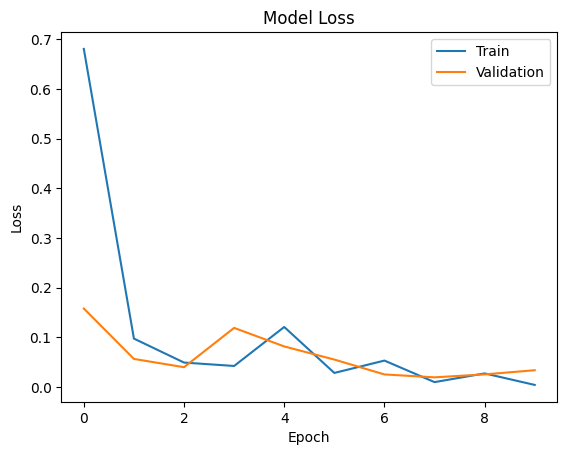

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Data Augmentation

**Data Augmentation** ou en français **l’augmentation du jeu de données** est une technique qui permet d’améliorer la précision du modèle.

En effet, cette technique consiste à modifier, transformer les données existantes afin de diversifier le dataset et permettre au modèle de s’entraîner sur de nouvelles données.

Par exemple pour des images, il est possible de jouer sur des transformations géométriques telles que des redimensionnements, des rotations mais aussi sur des transformations colorimétriques comme des changements de contrastes ou de luminosité entre autres.

Pour cela, on utilise la classe ``ImageDataGenerator``. En créant une nouvelle instance de cette classe, on peut lui indiquer en paramètre les types de transformations que l'on souhaite appliquer. Ces transformations seront effectuées de manière aléatoire.

Dans le cas de ``train_datagen``, le jeu de données utilisé pour l'entraînement du modèle, on indique que l'on souhaite réaliser des retournements verticaux et horizontaux.

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

La méthode ``flow`` permet de donner au générateur les données que l'on souhaite augmenter ainsi que les labels associés.

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

Ci-dessous, nous créons une nouvelle fois un modèle, qui prend exactement les mêmes paramètres que les deux précédents.


In [ ]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_2 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 246016)           

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Cette fois-ci, nous allons transmettre au modèle les données qui ont été augmentées.

In [ ]:
history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)

Epoch 1/5


<ipython-input-31-6ec88e3e8198>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)


103/103 [==============================] - 161s 2s/step - loss: 1.5012 - accuracy: 0.4404 - val_loss: 1.0205 - val_accuracy: 0.3745
Epoch 2/5
103/103 [==============================] - 166s 2s/step - loss: 0.8522 - accuracy: 0.6058 - val_loss: 0.6723 - val_accuracy: 0.7818
Epoch 3/5
103/103 [==============================] - 147s 1s/step - loss: 0.5690 - accuracy: 0.7847 - val_loss: 0.4073 - val_accuracy: 0.8545
Epoch 4/5
103/103 [==============================] - 164s 2s/step - loss: 0.3637 - accuracy: 0.8783 - val_loss: 0.3488 - val_accuracy: 0.8764
Epoch 5/5
103/103 [==============================] - 149s 1s/step - loss: 0.1930 - accuracy: 0.9367 - val_loss: 0.2105 - val_accuracy: 0.9200


# Results

Après avoir appliqué les techniques de 'Data Augmentation' pour enrichir notre ensemble de données, il est essentiel d'évaluer comment ces augmentations influencent les performances du modèle.

<u> Rapport de classification </u>
*   Classe 0:
  *   Une precision de 0.75 indique que sur toutes les prédictions de la classe 0, 75% étaient correctes.
  *   Un recall de 0.90 signifie que le modèle a identifié 90% des instances réelles de la classe 0 dans l'ensemble de validation.
  *   Un F1-score de 0.82 suggère un équilibre entre la precision et le recall, cependant, il y a toujours une marge d'amélioration étant donné qu'un score parfait serait de 1.
*   Classe 1 :      
  *   La precision est de 0.95
  *   Le recall est de 0.96 donc le modèle a identifié 96% des instances réelles de la classe 1.
  * Cette classe présente le F1-score le plus élevé parmi les trois (0.96), le modèle est très performant pour détecter et classer correctement cette classe.
*   Classe 2 :     
  *   Une precision de 0.94 indique que 94% des prédictions de la classe 2 étaient correctes
  *   Les recall est égale à 0.87
  *   F1-score = 0.90. Tout comme la classe 1, le modèle a une performance élevée pour cette classe.

<u> Matrice de confusion </u>

Rappel : La matrice de confusion donne une représentation tabulaire des prédictions du modèle par rapport aux véritables labels (i.e. elle montre les prédictions du modèle par rapport aux vraies valeurs).

Pour cet ensemble de validation on a :

*   Classe 0 :     
  - Vrais positifs (VP) : 27 instances ont été correctement identifiées comme appartenant à la classe 0
  - Faux positifs (FP) : 9 (2 instances de la classe 1 et 7 instances de la classe 2 ont été incorrectement classifiée comme appartenant à la classe 0)
  - Faux négatifs (FN) : 3 instances ont été incorrectement classée comme n'appartenant pas à la classe 0 alors qu'elle en fait partie.
*   Classe 1 :    
  - Vrais positifs (VP) : 136 instances ont été correctement identifiées comme appartenant à la classe 1
  - Faux positifs (FP) : 7 instances de la Classe 2 ont été incorrectement classifié comme appartenant à la Classe 1
  - Faux négatifs (FN) : 5 (2+3) instances de la classe 1 ont été incorrectement identifiées comme n'appartenant pas à cette classe
*   Classe 2 :    
  - Vrais positifs (VP) : 90 instances ont été correctement identifiées comme appartenant à la classe 2
  - Faux positifs (FP) : 3 instances de la Classe 0 et 3 instances de la Classe 1 ont été prédites comme appartenant à la classe 2. Donc FP = 6
  - Faux négatifs (FN) : 14 instances ont été incorrectement classée comme n'apartenant pas à la classe 2 : 7 devraient appartenir à la classe 0 et les 7 autres à la classe 1.

In [ ]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 14s 2s/step
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        30
           1       0.95      0.96      0.96       141
           2       0.94      0.87      0.90       104

    accuracy                           0.92       275
   macro avg       0.88      0.91      0.89       275
weighted avg       0.92      0.92      0.92       275

[[ 27   0   3]
 [  2 136   3]
 [  7   7  90]]


Pour conclure, la méthode d'entrainement du modèle utilisant SMOTE offre les meilleures performances en termes de précision globale et de F1-score pour chaque classe comparé à l'approche "Class weighted" et "Data Augmentation". Cependant l'utilisation de SMOTE peut aussi introduire du bruit si les échantillons synthétiques ne reflètent pas bien les données réelles.